# Support Work, IE World Conference

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from research_utils.database.database import Database

## Exploratory Analysis

This first part of our analysis is to make sure that the data set is sufficient diverse to support our purpose. In order to determine that, we look at the percentage of issues that were sourced from the crowd, and see how it varies along with other characteristics.

In [3]:
database = Database()

In [12]:
sql = """
SELECT CAST(a.crowd AS DECIMAL)/b.total as crowd_pct, a.package_id, c.package_name, b.total
FROM(
	SELECT COUNT(*) as crowd, package_id
	FROM open_source.issue_contributors
	WHERE commit_pct <= {pct}
	GROUP BY package_id
) a
INNER JOIN (
	SELECT COUNT(*) as total, package_id
	FROM open_source.issue_contributors
	GROUP BY package_id
) b
ON a.package_id = b.package_id
INNER JOIN open_source.packages c
ON a.package_id = c.id
WHERE b.total < 1000
"""

#### Crowd Sourcing in Open Source Projects

Based on our analysis of the data set, 964 project source requirements from the crowd. As we can see from the plots below, there is a wide distribution of contribution patters in our data set. The scatter plot also shows that contribution patterns vary widely by project size as well.

(0, 1)

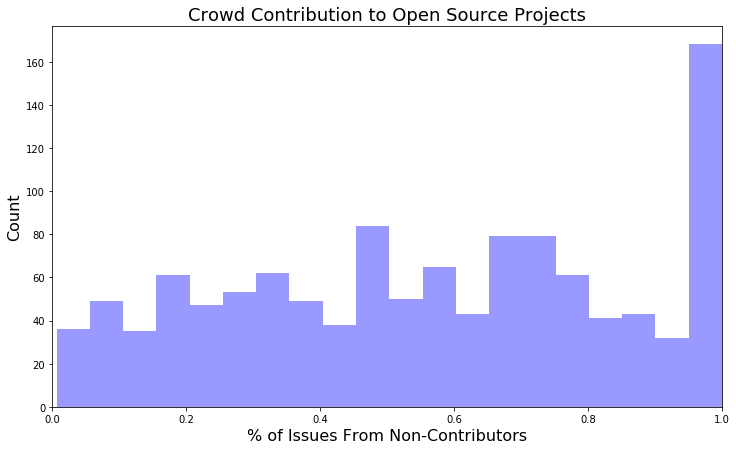

In [5]:
df = pd.read_sql(sql.format(pct=0.0), database.connection)
plt.figure(figsize=(12, 7))
sns.distplot(df['crowd_pct'], kde=False, color='blue', bins=20)
plt.title('Crowd Contribution to Open Source Projects', fontsize=18)
plt.xlabel('% of Issues From Non-Contributors', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,1])

#### Crowd Contribution and Issue Count

The purpose of this plot is to show that crowd contribution varies considerably with the size of networks. In particular, it's not only big or small projects that are sourcing issues from the crowd. A range of projects are sourcing projects from the crowd.

(0, 1)

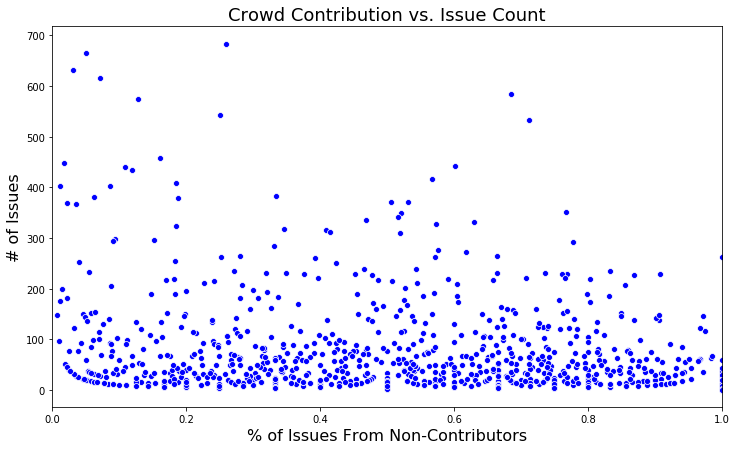

In [13]:
df = pd.read_sql(sql.format(pct=0.00), database.connection)
plt.figure(figsize=(12, 7))
sns.scatterplot(x=df['crowd_pct'], y=df['total'], color='blue')
plt.title('Crowd Contribution vs. Issue Count', fontsize=18)
plt.xlabel('% of Issues From Non-Contributors', fontsize=16)
plt.ylabel('# of Issues', fontsize=16)
plt.xlim([0,1])

#### Stakeholder Network Size

This plot shows the diversity of the stakeholder networks in terms of size. In particular, the data set contains a large number of networks with a small number of stakeholders, and small number of networks with a large number of stakeholders.

In [14]:
sql = """
select count(distinct user_id) as total, organization, package
from open_source.network_centrality
where betweenness_centrality > 0
group by organization, package
"""
df = pd.read_sql(sql, database.connection)

(0, 200)

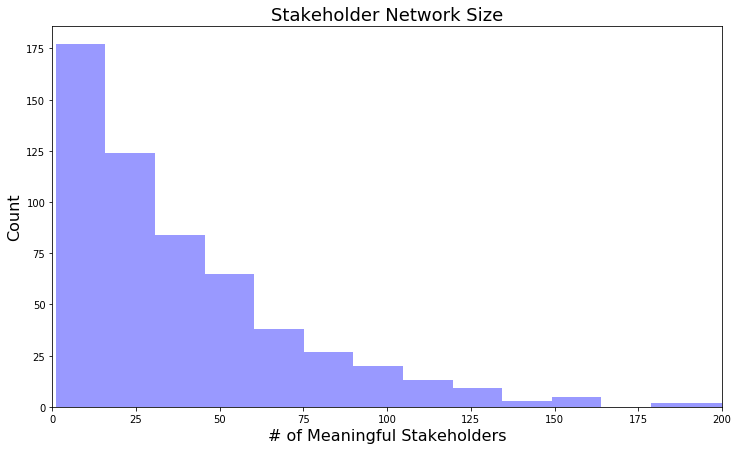

In [15]:
plt.figure(figsize=(12, 7))
sns.distplot(df['total'], kde=False, color='blue', bins=50)
plt.title('Stakeholder Network Size', fontsize=18)
plt.xlabel('# of Meaningful Stakeholders', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,200])

#### Diversity in Project Size

This plot shows that the data set contains a range of project sizes, and that the distribution of project sizes is relatively uniform.

In [16]:
sql = """
select count(distinct issue_id) as total, package, organization
from open_source.issue_comments
where package <> 'salt'
group by package, organization
"""
df = pd.read_sql(sql, database.connection)

(0, 1000)

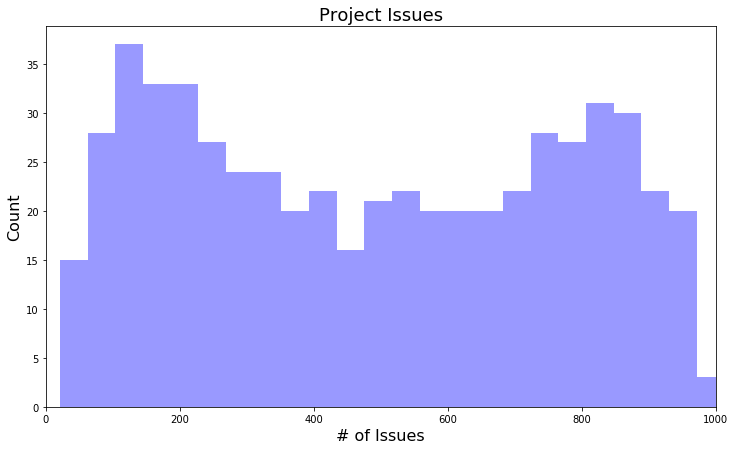

In [17]:
plt.figure(figsize=(12, 7))
sns.distplot(df['total'], kde=False, color='blue', bins=200)
plt.title('Project Issues', fontsize=18)
plt.xlabel('# of Issues', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,1000])

### Network Structure and Network Size

This section shows how various measure of network structure vary with the size of the network

In [19]:
sql = """
SELECT a.organization, a.package, gini_coefficient,
	   avg_clustering, avg_min_path, ks_pval,
        stakeholder_count, issue_count
FROM (
	SELECT organization, package, gini_coefficient,
           avg_clustering, avg_min_path, ks_pval
	FROM open_source.stakeholder_networks
    WHERE crowd_pct > .5
) a
INNER JOIN (
	SELECT organization, package, 
	COUNT(DISTINCT user_id) AS stakeholder_count,
	COUNT(DISTINCT issue_number) AS issue_count
	FROM open_source.issue_comments
	GROUP BY organization, package
) b
ON (a.package = b.package
AND a.organization = b.organization)
"""

In [20]:
df = pd.read_sql(sql, database.connection)

#### Gini Coefficient

The gini coefficient is a measure of the concentration of the network. As we see here, the networks in the data set span a wide range of concentrations. 

(0.3, 0.75)

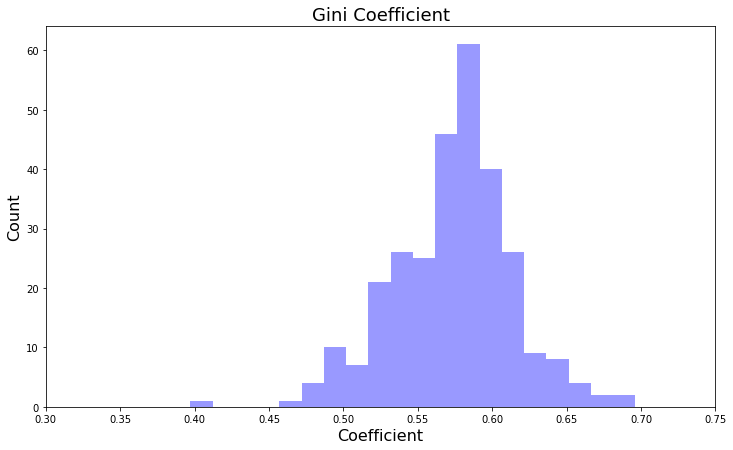

In [21]:
plt.figure(figsize=(12, 7))
sns.distplot(df['gini_coefficient'], kde=False, color='blue', bins=20)
plt.title('Gini Coefficient', fontsize=18)
plt.xlabel('Coefficient', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0.3,.75])

#### Gini Coefficient and Network Size

This plot shows that network concentration grows with network size, but it's a relatively loose relationship. Note, the scale for network size is a log scale. There is a stronger relationship between network concentration and issue count than there is between network concentration and stakeholder count.

Text(0, 0.5, 'Gini Coefficient')

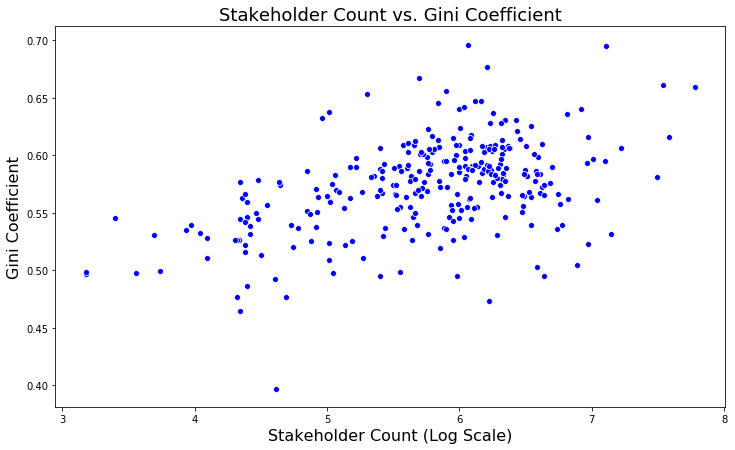

In [22]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=np.log(df['stakeholder_count']), y=df['gini_coefficient'], color='blue')
plt.title('Stakeholder Count vs. Gini Coefficient', fontsize=18)
plt.xlabel('Stakeholder Count (Log Scale)', fontsize=16)
plt.ylabel('Gini Coefficient', fontsize=16)

Text(0, 0.5, 'Gini Coefficient')

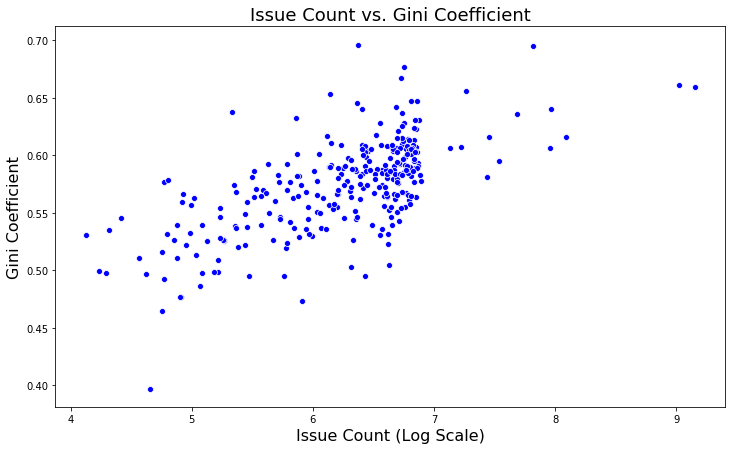

In [23]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=np.log(df['issue_count']), y=df['gini_coefficient'], color='blue')
plt.title('Issue Count vs. Gini Coefficient', fontsize=18)
plt.xlabel('Issue Count (Log Scale)', fontsize=16)
plt.ylabel('Gini Coefficient', fontsize=16)

#### Avg Min Path

The average minimum path is a measure of the breadth of the network. Again, network breadth takes on range of value, and there's only a loose relationship between the size of the relationship and the network breadth.

Text(0, 0.5, 'Avg Shortest Path')

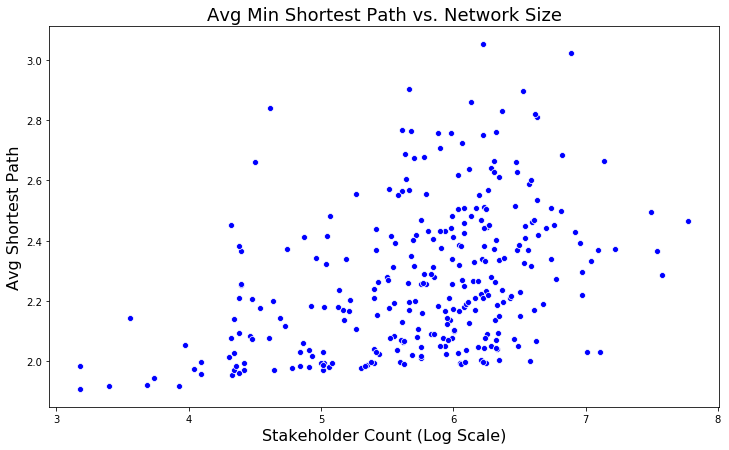

In [27]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x=np.log(df['stakeholder_count']), y=df['avg_min_path'], color='blue')
plt.title('Avg Min Shortest Path vs. Network Size', fontsize=18)
plt.xlabel('Stakeholder Count (Log Scale)', fontsize=16)
plt.ylabel('Avg Shortest Path', fontsize=16)

#### Clustering Coefficient and Avg Min Count

These plots show the distribution of avg min count and clustering coefficient across the data set. As with the gini coefficient, we see that the there's a strong diversity of network types in the dataset.

(0, 1)

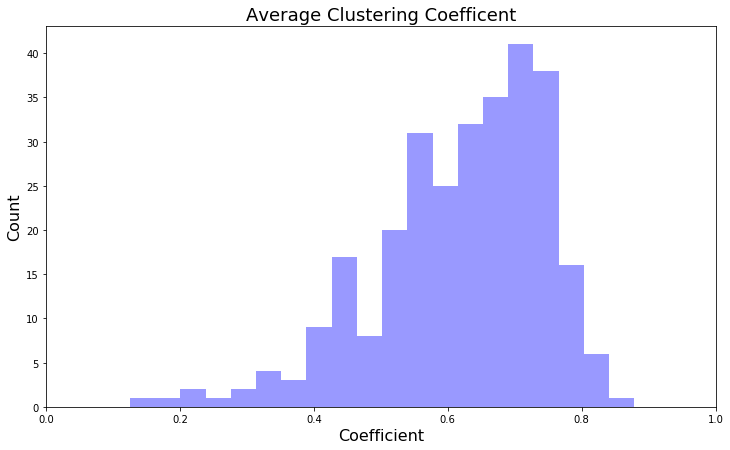

In [25]:
plt.figure(figsize=(12, 7))
sns.distplot(df['avg_clustering'], kde=False, color='blue', bins=20)
plt.title('Average Clustering Coefficent', fontsize=18)
plt.xlabel('Coefficient', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,1])

(1.4, 3.1)

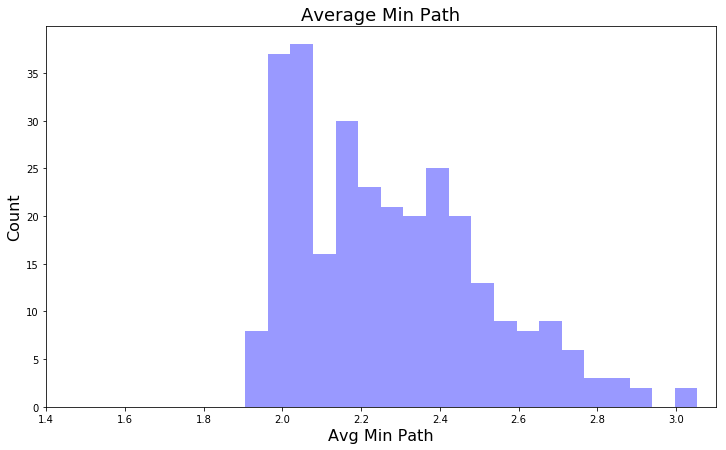

In [26]:
plt.figure(figsize=(12, 7))
sns.distplot(df['avg_min_path'], kde=False, color='blue', bins=20)
plt.title('Average Min Path', fontsize=18)
plt.xlabel('Avg Min Path', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1.4,3.1])

## Results

The following shows the supporting work for the statistical modeling that is done in the conference paper

### Read in Task Duration Data

This data reads in network characteristics from the tables the contain information on the stakeholder networks and joins them with a query that determines mean and median task completion time.

In [2]:
database = Database()

In [3]:
sql = """
SELECT a.package_id, a.package, a.organization,
	   a.duration_median, a.duration_mean, a.duration_variance, a.project_age,
	   b.crowd_pct, b.crowd, b.total as total_issues,
	   c.gini_coefficient, c.avg_clustering, c.avg_min_path,
	   d.total_contributors
FROM(
	SELECT package_id, package, organization,
		   PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY duration) AS duration_median,
		   AVG(duration) AS duration_mean,
		   VARIANCE(duration) AS duration_variance,
		   EXTRACT(DAY FROM NOW() - MIN(created_at)) AS project_age
	FROM(
		SELECT package_id, organization, package, created_at,
			   EXTRACT(DAY FROM closed_at - created_at) as duration
               FROM open_source.issues
               WHERE closed_at IS NOT NULL AND pull_request IS FALSE
               AND created_at < '2019-01-01'
                AND ('bug' = ANY(lower(labels::text)::text[])
                OR 'feature' = ANY(lower(labels::text)::text[])
            OR 'feature request' = ANY(lower(labels::text)::text[])
            OR 'change' = ANY(lower(labels::text)::text[])
            OR 'suggestion' = ANY(lower(labels::text)::text[])
            OR 'enhancement' = ANY(lower(labels::text)::text[]))
		
	) z
	GROUP BY package_id, organization, package
) a
INNER JOIN open_source.crowd_percentage b
ON a.package_id = b.package_id
INNER JOIN (
	SELECT organization, package, gini_coefficient, avg_clustering, avg_min_path, crowd_pct
	FROM open_source.stakeholder_networks
) c
ON (a.package = c.package AND a.organization = c.organization)
INNER JOIN (
	SELECT COUNT(DISTINCT user_id) as total_contributors, package_id
	FROM open_source.issue_contributors
    WHERE commit_pct > 0
	GROUP BY package_id
) d
ON a.package_id = d.package_id
"""
df = pd.read_sql(sql, database.connection)

In [4]:
len(df)

564

### Summary Statistics
Summary statistics for the variables, and plots of the dependent variables to get a feel for their distribution

In [5]:
df.describe()

,duration_median,duration_mean,duration_variance,project_age,crowd_pct,crowd,total_issues,gini_coefficient,avg_clustering,avg_min_path,total_contributors
count,564.000000,564.000000,563.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,75.835106,165.451520,73591.826275,1831.501773,0.482259,54.494681,122.081560,0.562130,0.601463,2.187843,11.583333
std,135.595376,157.567969,103737.523668,710.138594,0.264507,88.306034,148.717013,0.048281,0.140819,0.232144,10.661186
min,0.000000,1.107843,45.344690,290.000000,0.006711,1.000000,30.000000,0.285714,0.000000,1.400000,1.000000
25%,9.000000,63.198529,12580.254509,1384.750000,0.265306,20.000000,48.000000,0.535556,0.522731,2.012465,5.000000
50%,25.000000,117.559063,35876.391072,1850.000000,0.503369,34.000000,77.000000,0.568914,0.628192,2.147014,9.000000
75%,83.000000,209.985795,89214.656282,2348.500000,0.703698,66.000000,142.000000,0.592213,0.705734,2.331802,15.000000
max,1217.000000,1309.115385,871580.307692,5543.000000,0.985294,1670.000000,1913.000000,0.696200,0.878524,3.054147,86.000000


(0, 600)

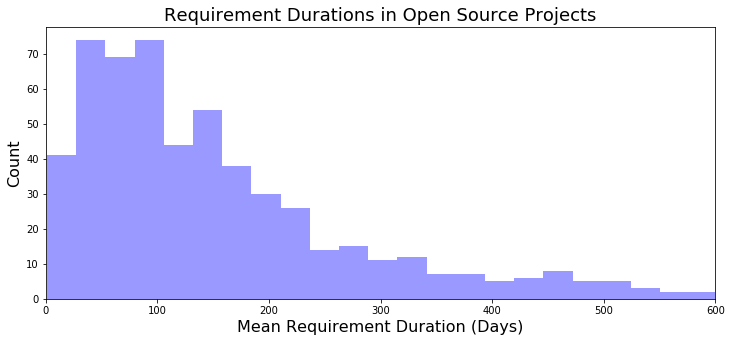

In [6]:
plt.figure(figsize=(12, 5))
sns.distplot(df['duration_mean'], kde=False, color='blue', bins=50)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Mean Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,600])

(0, 200)

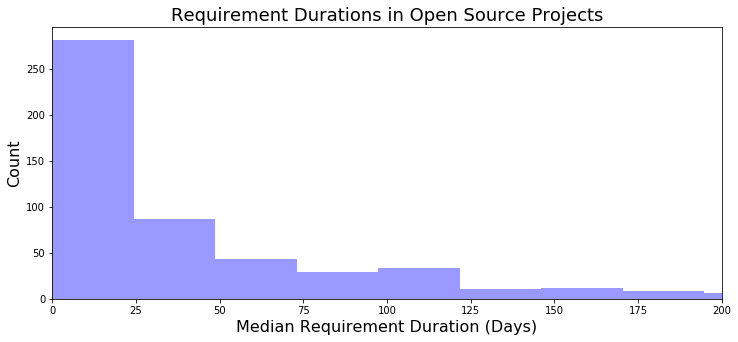

In [7]:
plt.figure(figsize=(12, 5))
sns.distplot(df['duration_median'], kde=False, color='blue', bins=50)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Median Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,200])

(0, 1000)

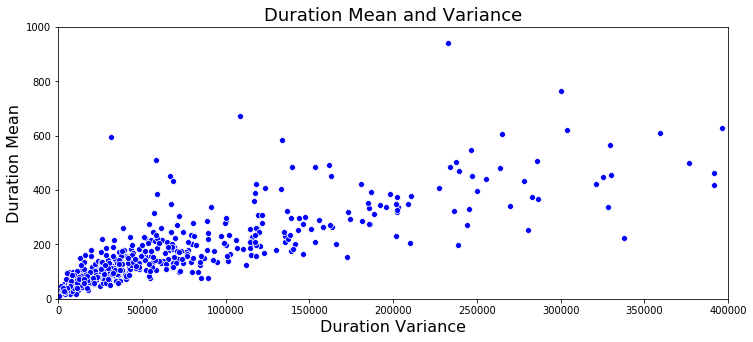

In [8]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df['duration_variance'], y=df['duration_mean'], color='blue')
plt.title('Duration Mean and Variance', fontsize=18)
plt.xlabel('Duration Variance', fontsize=16)
plt.xlim([0,400000])
plt.ylabel('Duration Mean', fontsize=16)
plt.ylim([0,1000])

(0, 1000)

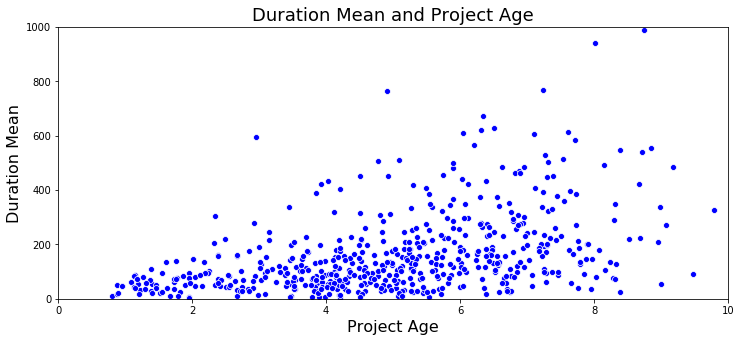

In [29]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df['project_age'], y=df['duration_mean'], color='blue')
plt.title('Duration Mean and Project Age', fontsize=18)
plt.xlabel('Project Age', fontsize=16)
plt.xlim([0,10])
plt.ylabel('Duration Mean', fontsize=16)
plt.ylim([0,1000])

(0, 1000)

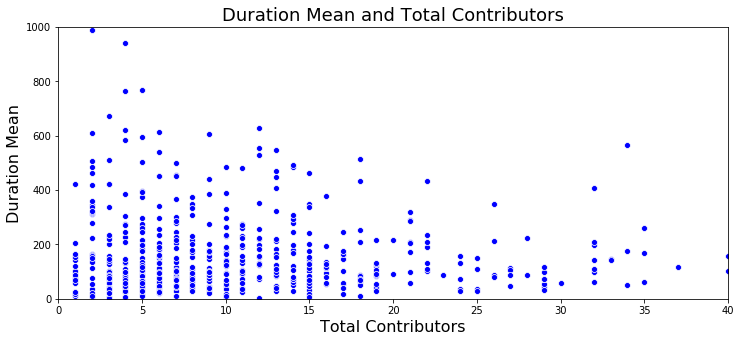

In [10]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df['total_contributors'], y=df['duration_mean'], color='blue')
plt.title('Duration Mean and Total Contributors', fontsize=18)
plt.xlabel('Total Contributors', fontsize=16)
plt.xlim([0,40])
plt.ylabel('Duration Mean', fontsize=16)
plt.ylim([0,1000])

### Data Transformation

Here, we multiplying crowd percentage by 100 so that the coefficients are more easily interpretable. In addition, project age is converted from days to months to years, again for interpretability. We also create interaction terms that we will use to determine how the impact of crowd sourcing changes as the structure of the networks changes.

In [11]:
df['crowd_pct'] = df['crowd_pct'] * 100
df['project_age'] = df['project_age']/365
df['gini_coefficientXcrowd_pct'] = df['gini_coefficient'] * df['crowd_pct']
df['avg_clusteringXcrowd_pct'] = df['avg_clustering'] * df['crowd_pct']
df['avg_min_pathXcrowd_pct'] = df['avg_min_path'] * df['crowd_pct']

### Regression Analysis

In the initial regression, we check to see if `crowd_pct` and the network structural variables have an impact on `duration_mean` by themselves. In the first regression, we see that `crowd_pct` has a positive impact on `duration_mean`, and that it's significant at the five percent significance level. All of the network structure variables with the exception of `gini_coefficient` are also significant in the second regression.

In [12]:
y, X = dmatrices('duration_mean ~ crowd_pct',
                 data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     34.62
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           6.90e-09
Time:                        10:21:52   Log-Likelihood:                -3636.7
No. Observations:                 564   AIC:                             7277.
Df Residuals:                     562   BIC:                             7286.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     96.2505     13.412      7.177      0.0

In [13]:
y, X = dmatrices('duration_mean ~ gini_coefficient + avg_min_path + avg_clustering',
                 data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     17.07
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           1.27e-10
Time:                        10:21:52   Log-Likelihood:                -3628.9
No. Observations:                 564   AIC:                             7266.
Df Residuals:                     560   BIC:                             7283.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -143.3711     85.945  

In the next set of regressions, we add in all of the network structure variables, and all some variables pertaining to the age and size of the project. All variables except for `total_issues` and `gini_coefficient` are significant at the ten percent significance level. The `crowd_pct` variable still has a positive effect in these regressions, but it is less positive than when we regressed on `crowd_pct` alone.

In [43]:
y, X = dmatrices('duration_mean ~ '
                 'crowd_pct + duration_variance + total_contributors + project_age + '
                 'gini_coefficient + avg_clustering + avg_min_path',
                 data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     208.6
Date:                Sun, 04 Aug 2019   Prob (F-statistic):          7.21e-151
Time:                        19:21:02   Log-Likelihood:                -3284.6
No. Observations:                 563   AIC:                             6585.
Df Residuals:                     555   BIC:                             6620.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -48.4205     55

In the next set of regressions, we remove the insignificant variables, and create an interaction term for `avg_clustering`. In both cases all of the variables are significant at the five percent significance level. The regression has a high `R2` and all variables are significant at the five percent significance level except for `avg_clustering` and `total_contributors`. We suspect that the lack of significance for these variables is related to multicollinearity.

In [15]:
y, X = dmatrices('duration_mean ~ '
                 'crowd_pct + duration_variance + project_age + total_contributors +'
                 'avg_clustering + avg_clusteringXcrowd_pct',
                 data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     251.2
Date:                Sun, 04 Aug 2019   Prob (F-statistic):          1.05e-154
Time:                        10:21:53   Log-Likelihood:                -3278.5
No. Observations:                 563   AIC:                             6571.
Df Residuals:                     556   BIC:                             6601.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [31]:
print(df['avg_clustering'].median())
crowd_effect = lambda cluster: res.params['crowd_pct'] + res.params['avg_clusteringXcrowd_pct']*cluster
crowd_effect(df['avg_clustering'].median())

0.6281921285294475


0.687608272438585

In [17]:
cluster_min, cluster_max = df['avg_clustering'].min(), df['avg_clustering'].max()
cluster = np.linspace(cluster_min, cluster_max)
crowd_coeff = [crowd_effect(x) for x in cluster]
effect_df = pd.DataFrame({'cluster': cluster, 'crowd_coeff': crowd_coeff})

In [18]:
effect_df.describe()

,cluster,crowd_coeff
count,50.000000,50.000000
mean,0.439262,0.092926
std,0.261359,0.822660
min,0.000000,-1.289707
25%,0.219631,-0.598390
50%,0.439262,0.092926
75%,0.658893,0.784243
max,0.878524,1.475560


The following plot shows how the coefficient for the impact of `crowd_pct` changes as `avg_clustering` changes, holding `avg_min_path` constant at it mean value.

Text(0, 0.5, 'Crowd Src Coeff')

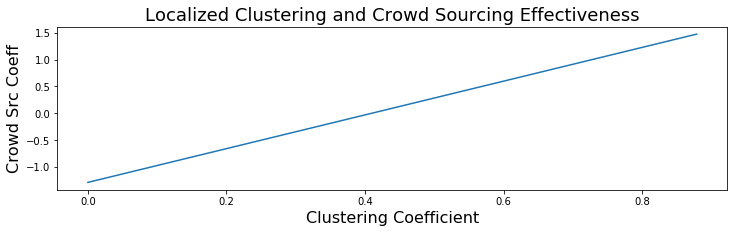

In [33]:
plt.figure(figsize=(12, 3))
sns.lineplot(x="cluster", y="crowd_coeff", data=effect_df)
plt.title('Localized Clustering and Crowd Sourcing Effectiveness', fontsize=18)
plt.xlabel('Clustering Coefficient', fontsize=16)
plt.ylabel('Crowd Src Coeff', fontsize=16)

### Regression Diagnostics

In [36]:
y, X = dmatrices('duration_mean ~ '
                 'crowd_pct + project_age + duration_variance + total_contributors +'
                 'avg_clustering + avg_clusteringXcrowd_pct',
                 data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     251.2
Date:                Sun, 04 Aug 2019   Prob (F-statistic):          1.05e-154
Time:                        16:03:07   Log-Likelihood:                -3278.5
No. Observations:                 563   AIC:                             6571.
Df Residuals:                     556   BIC:                             6601.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [21]:
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(res.resid, res.model.exog)
for i, name in enumerate(names):
    print('{}: {}'.format(name, test[i]))

Lagrange multiplier statistic: 83.79735264074539
p-value: 5.857735942613091e-16
f-value: 16.20446253271123
f p-value: 3.14759926232268e-17


One of the biggest concerns with using a standard OLS model instead of a more complicated GLM is that the domain of the predictor variable is strictly postive. Here we show that, although the model does produce some negative predictions, the overwhelming majority of the predictions of the model are positive. Given this results, the increased ease of interpreting the coefficients in the OLS model outweight the benefits of using a GLM.

In [22]:
pred = res.predict(X)

In [23]:
len([x for x in pred if x < 0]) / len(pred)

0.0

The variance inflation factors for the most part look fine. The high values are due to multicollinearity between `crowd_pct` and the interaction terms between `crowd_pct` and the network structure variables, which is to be expected. 

In [35]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

[27.73941289641178, 1.072342036802983, 1.2873385180336405, 1.3442497273647467, 1.0737618526321988, 1.1503535975746535]


The OLS residuals appear reasonably normal, which argues in favor of using an OLS model. It is noteworthy that the distribution has a longer right tail than we would expect from a normal distribution. However, we do not expect that this will materially impact the results of the model.

Text(0, 0.5, 'Count')

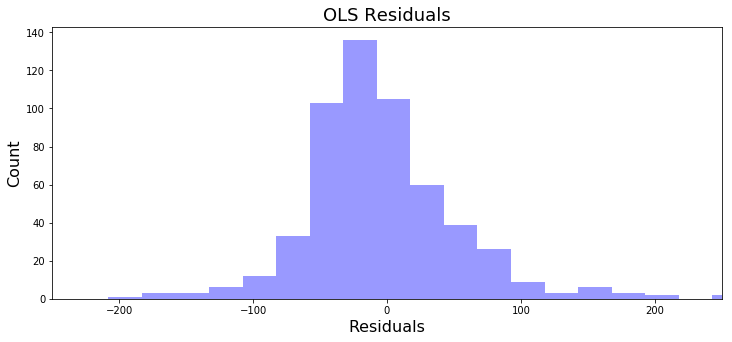

In [37]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.xlim([-250, 250])
plt.ylabel('Count', fontsize=16)

In [40]:
np.std(res.resid)

81.80072481170502

The plot of residuals against actuals shows that the residuals grow with the predictor. This indicates that the model suffers from heteroskedasticity. As a result, we will use heteroskedasticity robust standard errors for hypothesis testing.

(0, 600)

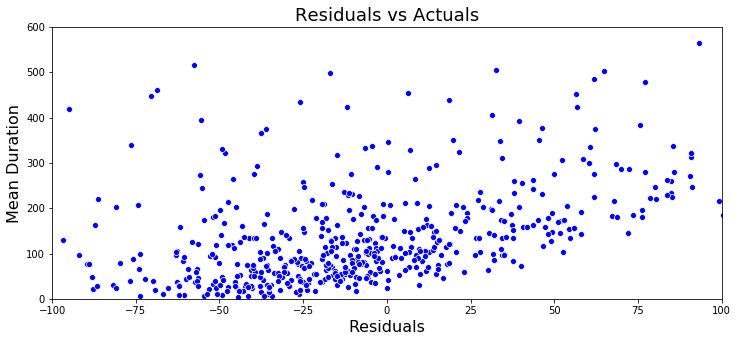

In [41]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=df['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.xlim([-100,100])
plt.ylabel('Mean Duration', fontsize=16)
plt.ylim([0,600])

The final results show the regression with heteroskedasticity robust standard error. In this regression, `total_contributors` becomes significant at the ten percent significance level. The lone `avg_clustering` variable remains insiginicant, but the interaction term is significant. The lone variable is probably insignificant due to multicollinearity.

In [27]:
robust_res = res.get_robustcov_results('HC1')
print(robust_res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     60.14
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           2.50e-57
Time:                        10:21:56   Log-Likelihood:                -3278.5
No. Observations:                 563   AIC:                             6571.
Df Residuals:                     556   BIC:                             6601.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               